# Рекомендация тарифов оператора мобильной связи

### Задача <a class = "tocSkip">

Построить для оператора мобильной связи модель, которая будет рекомендовать подходящий новый тариф для клиентов, продолжающих пользоваться архивными тарифами.

Модель должна демонстировать значение `accuracy` на тестовой выборке не менее 0.75.

### Предоставленные данные <a class = "tocSkip">

Исторические данные оператора о поведении клиентов мобильного оператора, которые перешли на новые тарифы. 

Согласно описанию к данным:

- `сalls` — количество звонков;
- `is_ultra` — каким тарифом клиент пользовался в течение месяца («Ультра» — 1, «Смарт» — 0, **целевой признак**).
- `minutes` — суммарная длительность звонков в минутах;
- `messages` — количество sms-сообщений;
- `mb_used` — израсходованный интернет-трафик в Мб;
  
Предоставленные данные прошли предобработку.

### План работы <a class = "tocSkip">

Работа будет включать пять этапов:

1. загрузка и изучение данных;
2. разделение данных на выборки;
3. исследование моделей на основе различных алгоритмов и выбор лучшей модели;
4. проверка лучшей модели на тестовой выборке;
5. сравнение лучшей модели с лучшей простейшей моделью.

## Загрузка и изучение данных

In [1]:
# импортирование библиотек

import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# установление единого стиля для графиков
sns.set_style("whitegrid")

# отключение предупреждений
warnings.filterwarnings('ignore')

Прочитаем файл с данными:

In [2]:
# чтение файла с данными
df = pd.read_csv('/datasets/users_behavior.csv')

Изучим пять случайных строк из набора:

In [3]:
# вывод на экран пяти случайных строк
display(df.sample(5))

,calls,minutes,messages,mb_used,is_ultra
2948,18.0,92.38,0.0,4060.64,1
992,82.0,569.13,24.0,18749.93,0
409,63.0,440.74,46.0,15677.49,1
1837,7.0,41.27,89.0,27950.85,1
629,123.0,947.71,57.0,24046.86,1


Также изучим общую информацию о наборе данных:

In [4]:
# вывод на экран общей информации о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Дополнительно посчитаем долю пользователей в наборе данных, пользующихся каждым тарифом:

In [5]:
# группировка данных по значению столбца is_ultra и расчет доли каждого значения
df.groupby('is_ultra')['is_ultra'].count()/len(df)

is_ultra
0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

### Выводы

- в наборе данных 3 214 объектов; 
- по каждому объекту доступно 5 признаков; целевой признак (тариф) содержится в столбце `is_ultra`;
- соотношение долей пользователей тарифов «Смарт» и «Ультра» составляет ~69/31.

## Разделение данных на выборки

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 4/1 (сохранив изначальное распределение целевого признака в новых выборках при помощи стратификации):

In [6]:
# разделение данных на обучающую и тестовую выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345, stratify=df['is_ultra'])

# присваивание выборкам имен
df_train.name = 'train'
df_test.name = 'test'

# проверка разделения данных на выборки и распределения целевого признака в новых выборках
for df in df_train, df_test:
    print(df.name)
    print(f'Количество объектов в выборке: {len(df)}')
    print(df.groupby('is_ultra')['is_ultra'].count()/len(df))
    print()

train
Количество объектов в выборке: 2571
is_ultra
0    0.693504
1    0.306496
Name: is_ultra, dtype: float64

test
Количество объектов в выборке: 643
is_ultra
0    0.693624
1    0.306376
Name: is_ultra, dtype: float64



Для каждой выборки сохраним целевой признак и прочие признаки в отдельные переменные:

In [7]:
# для каждой выборки создание переменных features и target, содержащих признаки и целевой признак
train_features = df_train.drop('is_ultra', axis=1)
train_target = df_train['is_ultra']
test_features = df_test.drop('is_ultra', axis=1)
test_target = df_test['is_ultra']

# проверка создания переменных
for feature in train_features, train_target, test_features, test_target:
    print(feature.shape)

(2571, 4)
(2571,)
(643, 4)
(643,)


## Исследование моделей на основе различных алгоритмов и выбор лучшей модели

Исследуем модели, использующие следующие алгоритмы:

1. решающее дерево;
2. случайный лес; и
3. логистическая регрессия.

Для каждого алгоритма:

- создадим модель;
- при помощи GridSearchCV оптимизируем значения гиперпараметров, чтобы получить лучшее значение accuracy.

### Исследование модели решающего дерева

Проведем исследование модели решающего дерева. Для достижения лучшего значения accuracy будем изменять гиперпараметр `max_depth` (от 1 до 10):

In [8]:
# создание словаря c гиперпараметром и диапазоном его значений, которые будут оптимизироваться
tree_param_dict = {'max_depth': range(1,11)}

# создание модели решающего дерева
tree_model = DecisionTreeClassifier(random_state=12345)

# оптимизация гиперпараметров
tree_grid = GridSearchCV(tree_model, param_grid=tree_param_dict, scoring='accuracy', cv=5, 
                         return_train_score=True, refit=True)
tree_grid.fit(train_features, train_target)

# создание переменных с лучшей моделью и лучшим accuracy
best_tree_model = tree_grid.best_estimator_
best_tree_model_accuracy = tree_grid.best_score_


# вывод на экран значений гиперпараметров и accuracy лучшей модели
print('accuracy лучшей модели решающего дерева:', best_tree_model_accuracy)
print('max_depth лучшей модели решающего дерева:', tree_grid.best_params_)

accuracy лучшей модели решающего дерева: 0.7977462128366892
max_depth лучшей модели решающего дерева: {'max_depth': 6}


Лучшее значение accuracy (~0,798) показала модель со значением гиперпараметра `max_depth`, равным 6.

Посмотрим, как менялось значение accuracy в зависисмости от значения `max_depth`:

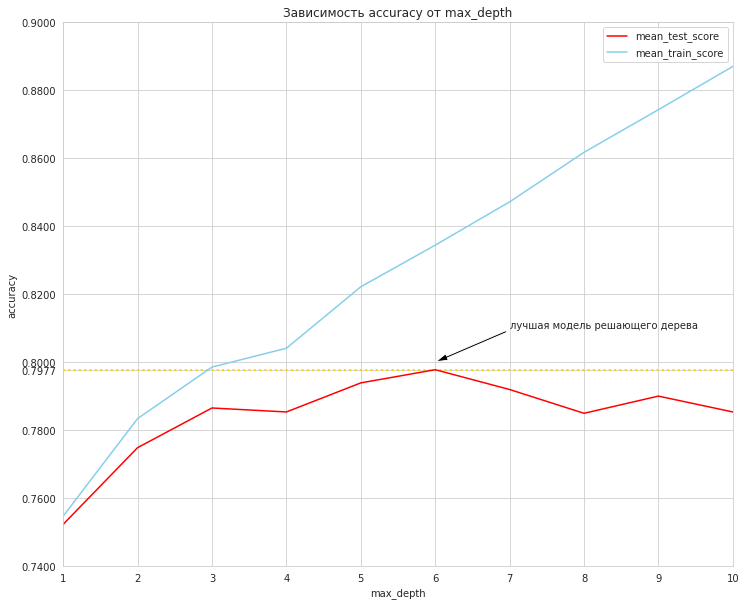

In [9]:
# создание датасета с данными о значении гиперпараметра и accuracy
tree_param_scores = (
    pd.DataFrame({
        "mean_test_score": tree_grid.cv_results_["mean_test_score"],
        "mean_train_score": tree_grid.cv_results_["mean_train_score"]})
    .join(pd.json_normalize(tree_grid.cv_results_["params"]).add_prefix("param_"))
)

tree_param_scores_grouped = pd.pivot_table(tree_param_scores, index=["param_max_depth"])

# построение графика
fig, ax = plt.subplots(figsize=(12,10))

ax.set_title('Зависимость accuracy от max_depth')

sns.lineplot(data=tree_param_scores_grouped, palette=['red', 'skyblue'], dashes=False, ax=ax)

ax.hlines(y=tree_grid.best_score_, xmin=1, xmax=10, linewidth=2, color='gold', linestyles='dotted')

ax.set_xlim(1, 10)
ax.set_ylim(0.74, 0.9)

xticks = list(range(1,11))
ax.set_xticks(xticks)

yticks = [0.74, 0.76, 0.78, tree_grid.best_score_, 0.80, 0.82, 0.84, 0.86, 0.88, 0.90]
ax.set_yticks(yticks)

ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')

ax.annotate("лучшая модель решающего дерева", 
            xy=(6, 0.8), 
            xytext=(7, 0.81),
            arrowprops=dict(facecolor='black',width=2.0,headwidth=7.0,headlength=12.0,shrink=0.01)
           )

plt.show()

При значении гиперпараметра выше наблюдается переобучение модели.

### Исследование модели случайного леса

Проведем исследование модели случайного леса. Для достижения лучшего значения accuracy будем изменять гиперпараметры: 
- `max_depth` (от 1 до 15 с шагом 2);
- `n_estimators` (от 1 до 15 с шагом 2).

In [10]:
%%time

# создание словаря c гиперпараметрами и диапазоном их значений, которые будут оптимизироваться
forest_param_dict = {
    'max_depth': range(1,16,2),
    'n_estimators': range(1,16,2)
}

# создание модели случайного леса
forest_model = RandomForestClassifier(random_state=12345)

# оптимизация гиперпараметров
forest_grid = GridSearchCV(forest_model, param_grid=forest_param_dict, scoring='accuracy', cv=5, 
                         return_train_score=True, refit=True)
forest_grid.fit(train_features, train_target)

# создание переменных с лучшей моделью и лучшим accuracy
best_forest_model = forest_grid.best_estimator_
best_forest_model_accuracy = forest_grid.best_score_

# вывод на экран значений гиперпараметров и accuracy лучшей модели
print('accuracy лучшей модели случайного леса:', best_forest_model_accuracy)
print('max_depth и n_estimators лучшей модели случайного леса:', forest_grid.best_params_)

accuracy лучшей модели случайного леса: 0.8043640210041177
max_depth и n_estimators лучшей модели случайного леса: {'max_depth': 11, 'n_estimators': 15}
CPU times: user 9.43 s, sys: 33.4 ms, total: 9.47 s
Wall time: 10.2 s


Лучшее значение accuracy на валидационной выборке (~0,804) показала модель со значениями гиперпараметров:
- `max_depth`, равным 11;
- `n_estimators`, равным 15.

Посмотрим, как менялась accuracy в зависимости от различных значений `max_depth` и `n_estimators`:

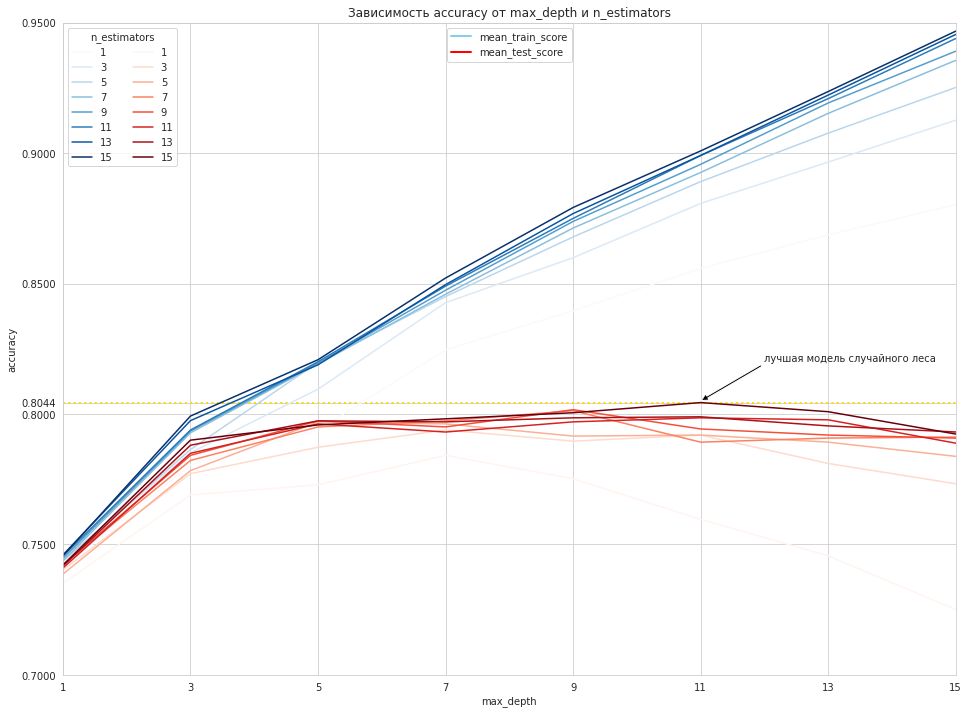

In [11]:
# создание датасета со значениями гиперпараметров и accuracy
forest_param_scores = (
    pd.DataFrame({
        "mean_test_score": forest_grid.cv_results_["mean_test_score"],
        "mean_train_score": forest_grid.cv_results_["mean_train_score"]})
    .join(pd.json_normalize(forest_grid.cv_results_["params"]).add_prefix("param_"))
)

# построение графика изменения accuracy
fig, ax = plt.subplots(figsize=(16,12))

ax.set_title('Зависимость accuracy от max_depth и n_estimators')

sns.lineplot(data=forest_param_scores, x="param_max_depth", 
             y="mean_train_score", hue="param_n_estimators", palette="Blues", ax=ax, legend='full')
sns.lineplot(data=forest_param_scores, x="param_max_depth", y="mean_test_score", 
             hue="param_n_estimators", palette="Reds", ax=ax, legend='full')
ax.hlines(y=forest_grid.best_score_, xmin=1, xmax=15, linewidth=2, color='gold', linestyles='dotted')

ax.set_xlim(1, 15)
ax.set_ylim(0.725, 0.95)

xticks = list(range(1, 16, 2))
ax.set_xticks(xticks)

yticks = [0.7, 0.75, 0.80, forest_grid.best_score_, 0.85, 0.90, 0.95]
ax.set_yticks(yticks)

ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')

ax.annotate("лучшая модель случайного леса", 
            xy=(11, 0.805), 
            xytext=(12, 0.82),
            arrowprops=dict(facecolor='black',width=2.0,headwidth=7.0,headlength=7.0,shrink=0.01)
           )

legend_elements = [Line2D([0], [0], color='skyblue', lw=2, label='mean_test_score'),
                   Line2D([0], [0], color='red', lw=2, label='mean_train_score')]
legend_1 = ax.legend(title="n_estimators", ncol=2, loc='upper left')
legend_2 = ax.legend(legend_elements, ['mean_train_score', 'mean_test_score'], loc='upper center')
ax.add_artist(legend_1)

plt.show()

Мы видим, что в зависимости от количества деревьев переобучение модели начинается со значения max_depth, равного 9-13.

### Исследование модели логистической регрессии

Проведем исследование модели логической регрессии. Для достижения лучшего значения accuracy будем изменять гиперпараметры: 
- `solver` (`newton-cg`, `lbfgs`, `liblinear`);
- `penalty` (`l2`, `none` и `l1`).

In [12]:
# создание словаря c гиперпараметрами и диапазоном их значений, которые будут оптимизироваться
logreg_param_dict = {
    'penalty' : ['l1','l2', 'none'], 
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

# создание модели логистической регрессии
logreg_model = LogisticRegression(random_state=12345, max_iter=10000) 

# оптимизация гиперпараметров
logreg_grid = GridSearchCV(logreg_model, param_grid=logreg_param_dict, scoring='accuracy', cv=5, 
                         return_train_score=True, refit=True)
logreg_grid.fit(train_features, train_target)

# создание переменных с лучшей моделью и лучшим accuracy
best_logreg_model = logreg_grid.best_estimator_
best_logreg_model_accuracy = logreg_grid.best_score_

# вывод на экран значений гиперпараметров и accuracy лучшей модели
print('accuracy лучшей модели логистической регрессии:', best_logreg_model_accuracy)
print('max_depth и n_estimators лучшей модели логистической регрессии:', logreg_grid.best_params_)

accuracy лучшей модели логистической регрессии: 0.7483510256507121
max_depth и n_estimators лучшей модели логистической регрессии: {'penalty': 'l1', 'solver': 'liblinear'}


Лучшее значение accuracy на валидационной выборке (~0,748) показала модель со значениями гиперпараметров:
- `solver`, равным `liblinear`;
- `penalty`, равным `l1`.

<AxesSubplot:xlabel='calls', ylabel='messages'>

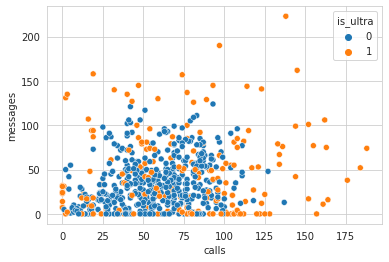

In [13]:
sns.scatterplot(data=df, x='calls', y='messages', hue="is_ultra")

### Выбор лучшей модели

Сравним accuracy лучших моделей каждого алгоритма: 

In [14]:
# создание списков с лучшими моделями каждого алгоритма и значениями их accuracy
best_models = [best_tree_model, best_forest_model, best_logreg_model]
best_models_accuracies = [best_tree_model_accuracy, best_forest_model_accuracy, 
                          best_logreg_model_accuracy]

# создание переменных для сохранения лучшей модели, ее алгоритма и значения ее accuracy
best_overall_model = None
best_overall_model_algorithm = None
best_overall_model_accuracy = 0

# создание цикла, который сравнит значения accuracy лучших моделей и присвоит вышеуказанным переменным значения 
# модели с наибольшим значением accuracy
for model, accuracy in zip(best_models, best_models_accuracies):
    if accuracy > best_overall_model_accuracy:
        best_overall_model = model
        best_overall_model_algorithm = type(model).__name__.removesuffix('Classifier').lower()
        best_overall_model_accuracy = accuracy

# вывод на алгоритма и accuracy лучшей модели
print('Алгоритм лучшей модели:', best_overall_model_algorithm)
print('accuracy лучшей модели:', best_overall_model_accuracy)

Алгоритм лучшей модели: randomforest
accuracy лучшей модели: 0.8043640210041177


### Выводы

По итогам сравнения лучших моделей на основе агоритмов решающего дерева, случайного леса и логистической регрессии лучшей моделью стала модель случайного леса со значением accuracy, равным ~0,804.

## Проверка лучшей модели на тестовой выборке

Проверим лучшую модель на тестовой выборке:

In [15]:
# расчет accuracy на тестовой выборке для лучшей модели
best_overall_model_test_accuracy = best_overall_model.score(test_features, test_target)

# вывод на экран accuracy на тестовой выборке для лучшей модели
print('accuracy лучшей модели на тестовой выборке:', best_overall_model_test_accuracy)

accuracy лучшей модели на тестовой выборке: 0.807153965785381


### Выводы

Лучшая модель показала на тестовой выборке accuracy ~0,807, что выше минимального значения accuracy, установленного в ТЗ (0,75).

## Сравнение лучшей модели с простейшей моделью

Для проверки качества построенной лучшей модели сравним ее простейшей моделью. Для этого сначала построим лучшую простейшую модель. Для достижения лучшего значения accuracy будем изменять гиперпараметр `strategy`:

In [16]:
# создание словаря c гиперпараметрами и диапазоном их значений, которые будут оптимизироваться
dummy_param_dict = {'strategy': ['most_frequent', 'stratified', 'uniform', 'constant']}

# создание простейшей модели
dummy_model = DummyClassifier(random_state=12345, constant=1)

# оптимизация гиперпараметров
dummy_grid = GridSearchCV(dummy_model, param_grid=dummy_param_dict, scoring='accuracy', cv=5, 
                         return_train_score=True, refit=True)
dummy_grid.fit(train_features, train_target)

# создание переменных с лучшей моделью и лучшим accuracy
best_dummy_model = dummy_grid.best_estimator_
best_dummy_model_accuracy = dummy_grid.best_score_

# вывод на экран значений гиперпараметров и accuracy лучшей модели
print('accuracy лучшей модели решающего дерева:', best_dummy_model_accuracy)
print('max_depth лучшей модели решающего дерева:', dummy_grid.best_params_)

accuracy лучшей модели решающего дерева: 0.6935045899286012
max_depth лучшей модели решающего дерева: {'strategy': 'most_frequent'}


Лучшее значение accuracy на валидационной выборке (~0,694) показала простейшая модель со значением гиперпараметра `strategy`, равным `most_frequent`.

Рассчитаем accuracy на тестовой выборке простейшей модели и сравним его с аналогичной метрикой лучшей модели:

In [17]:
# расчет accuracy на тестовой выборке простейшей модели 
best_dummy_model_test_accuracy = best_dummy_model.score(test_features, test_target)

# сравнение accuracy на тестовой выборке лучшей модели и простейшей модели 
if best_overall_model_test_accuracy > best_dummy_model_test_accuracy:
    print('accuracy на тестовой выборке лучшей модели выше')
elif best_overall_model_test_accuracy < best_dummy_model_test_accuracy:
    print('accuracy на тестовой выборке простейшей модели выше')
else:
    print('лучшая модель и простейшая модель показали одинаковое accuracy на тестовой выборке')

accuracy на тестовой выборке лучшей модели выше


### Выводы

Лучшая модель показала на тестовой выборке более высокое значение accuracy, чем простейшая модель.

## Общие выводы

На основе предоставленных данных о поведении клиентов мобильного оператора, перешедших на новые тарифы, мы построили модель, которая будет рекомендовать подходящий новый тариф для клиентов, продолжающих пользоваться архивными тарифами. 

Работа состояла из пяти этапов:

1. загрузка и изучение данных;
2. разделение данных на выборки;
3. исследование моделей на основе различных алгоритмов и выбор лучшей модели;
4. проверка лучшей модели на тестовой выборке;
5. сравнение лучшей модели с лучшей простейшей моделью.


**1. Загрузка и изучение данных**

На данном этапе мы загрузили и изучили предоставленные данные. По итогам их изучения мы установили:

- в наборе данных 3 214 объектов; 
- по каждому объекту доступно 5 признаков; целевой признак (тариф) содержится в столбце `is_ultra`;
- соотношение долей пользователей тарифов «Смарт» и «Ультра» составляет ~69/31.

**2. Разделение данных на выборки** 

На данном этапе мы:

- разделили данные на обучающую и тестовую выборки в пропорции 4/1 (сохранив изначальное распределение целевого признака в новых выборках при помощи стратификации);
- для каждой выборки сохранили параметры и целевой параметр в отдельные переменные.

**3. Исследование моделей на основе различных алгоритмов и выбор лучшей модели** 

На данном этапе мы исследовали модели, использующие следующие алгоритмы:

1. решающее дерево;
2. случайный лес; и
3. логистическая регрессия.

Для каждого алгоритма мы:

- провели обучение модели на обучающей выборке;
- при помощи GridSearchCV оптимизируем значения гиперпараметров, чтобы получить лучшее значение accuracy.

По итогам сравнения лучших моделей на основе агоритмов решающего дерева, случайного леса и логистической регрессии лучшей моделью стала модель случайного леса со значением accuracy, равным ~0,804.

**4. Проверка лучшей модели на тестовой выборке** 

На данном этапе мы проверили лучшую модель на тестовой выборке. Лучшая модель показала на тестовой выборке accuracy ~0,807, что выше минимального значения accuracy, установленного в ТЗ (0,75).

**5. Сравнение лучшей модели с лучшей простейшей моделью** 

На данном этапе мы:

- построили лучшую простейшую модель (модель с самыс высоким значением accuracy на валидационной выборке) путем подбора значений гиперпараметра `strategy`;
- сравнили accuracy на тестовой выборке лучшей простейшей модели и лучшей модели.

Лучшая модель показала на тестовой выборке более высокое значение accuracy, чем простейшая модель.